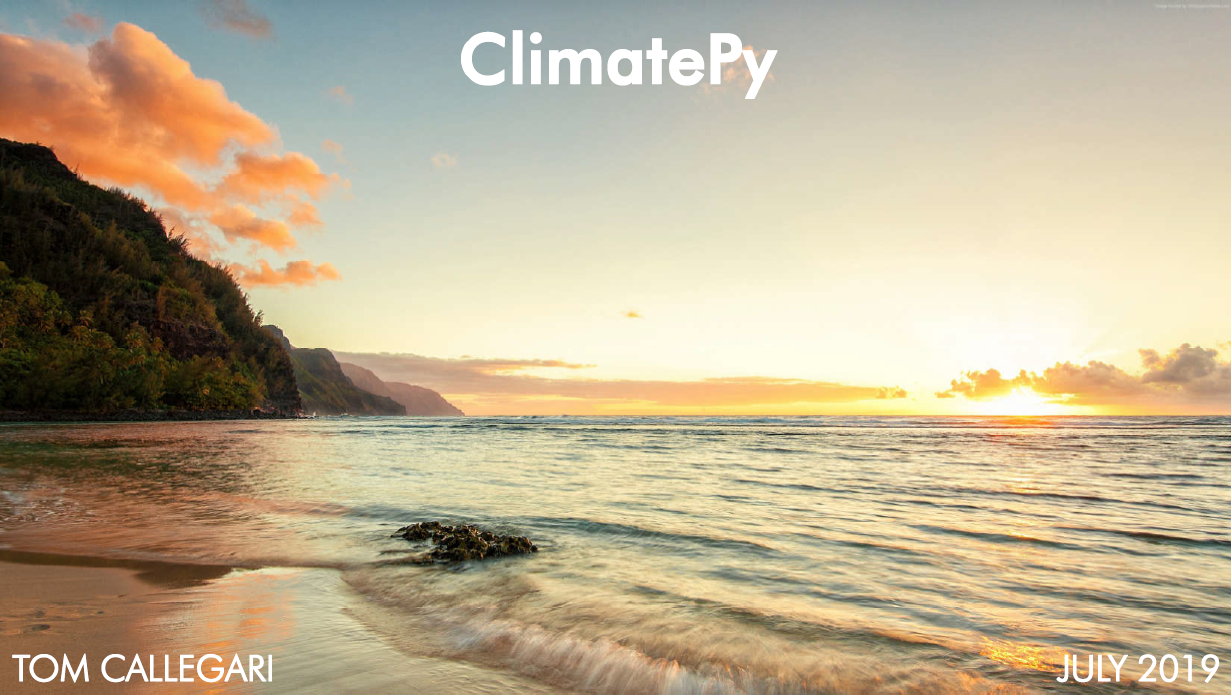

In [1]:
from IPython.display import Image
Image(filename = 'title_slide.png', width = 2000, height = 2000)

## Environment and ORM Setup

#### Dependencies and Packages

In [2]:
# Package dependencies
import matplotlib.pyplot as plt
from matplotlib import style
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
import datetime as dt

%matplotlib inline

# SQLAlchemy Object Relational Mapper (ORM)
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect
from sqlalchemy import Column, Integer, String, Float
from sqlalchemy.sql import select

#### SQLAlchemy ORM Setup

In [3]:
# Create SQLite Engine
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

# Create our session (link) from Python to the DB
session = Session(engine)

# Create a connection
conn = engine.connect()

### Inspect Object Tables

In [4]:
# Create an inspectiion object and get table names
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

#### Measurement Table

In [5]:
# Inspect the Measurement table
measurement_columns = inspector.get_columns('measurement')

for column in measurement_columns:
    print(column['name'], column['type'])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


#### Station Table

In [6]:
station_columns = inspector.get_columns('station')
for column in station_columns:
    print(column['name'], column['type'])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


<center><h1>Part 1 - Climate Analysis and Exploration</center></h1>

<center><h2>Preciptation Analysis</center></h2>

* Calculate the date 1 year ago from the last data point in the database
* Perform a query to retrieve the data and precipitation scores
* Save the query results as a Pandas DataFrame and set the index to the date column
* Sort the dataframe by date
* Use Pandas Plotting with Matplotlib to plot the data

--------------------------------------------------------------------------------------------------------------------------
#### NOTE: For each query the Pandas/SQL tectual query syntax is used as well as the SQLAlchemy ORM syntax
--------------------------------------------------------------------------------------------------------------------------

### Latest Year Query

* Design a query to retrieve the last 12 months of precipitation data and plot the results

#### Pandas / SQL 

In [7]:
year = pd.read_sql('''SELECT 
                        m.date AS Date, 
                        round(avg(m.tobs), 2) AS Temperature, 
                        round(sum(m.prcp), 2) AS Precipitation
                      FROM measurement AS m
                      GROUP BY m.date
                      ORDER BY m.date ASC;''', conn)

year['Date'] = pd.to_datetime(year['Date'])
year = year[year['Date'] >= '2016-08-23']
year.head()

,Date,Temperature,Precipitation
2426,2016-08-23,78.29,2.71
2427,2016-08-24,77.57,9.33
2428,2016-08-25,79.43,0.54
2429,2016-08-26,80.50,0.10
2430,2016-08-27,76.83,0.32


#### SQLAlchemy ORM

In [31]:
select = [
    Measurement.date.label('Date'), 
    func.sum(Measurement.prcp.label('Precipitation')), 
    func.avg(Measurement.tobs.label('Temperature'))
]

results = session.query(
    *select
).filter(
    Measurement.station == Station.station
).group_by(
    Measurement.date
).filter(
    Measurement.date >= '2016-08-23'
).all()

results_dict = {
    'Date': [result[0] for result in results],
    'Precipitation': [result[1] for result in results],
    'Temperature': [result[2] for result in results]
    
}

year = round(pd.DataFrame(results_dict), 2)
year['Date'] = pd.to_datetime(year['Date'])
year.head()

,Date,Precipitation,Temperature
0,2016-08-23,2.71,78.29
1,2016-08-24,9.33,77.57
2,2016-08-25,0.54,79.43
3,2016-08-26,0.10,80.50
4,2016-08-27,0.32,76.83


#### Latest Year Precipitation Plot

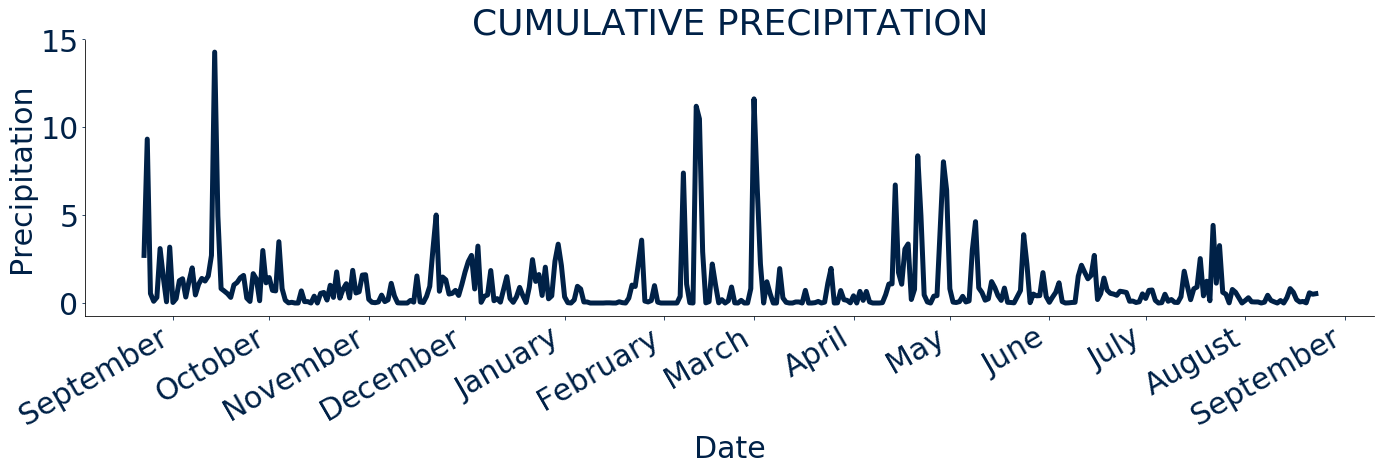

In [32]:
plt.rcParams.update({'font.size': 30})
plt.rcParams['axes.axisbelow'] = True

COLOR = '#002147'
plt.rcParams['text.color'] = COLOR
plt.rcParams['axes.labelcolor'] = COLOR
plt.rcParams['xtick.color'] = COLOR
plt.rcParams['ytick.color'] = COLOR
plt.rcParams['lines.color'] = COLOR
plt.rcParams['lines.linewidth'] = 2

months = mdates.MonthLocator()
months_fmt = mdates.DateFormatter('%B')

fig, ax = plt.subplots(1, figsize = [20, 7.25])

ax.plot(
    year['Date'], 
    year['Precipitation'], 
    color = '#002147',
    lw = 5
)

ax.xaxis.set_major_locator(months)
ax.xaxis.set_major_formatter(months_fmt)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_ylabel('Precipitation')
ax.set_xlabel('Date')
ax.set_title('CUMULATIVE PRECIPITATION')

fig.autofmt_xdate()

plt.tight_layout()
plt.savefig('Preciptation in One Year.png', transparent=True)

plt.show()

#### Latest Year Temperature Plot

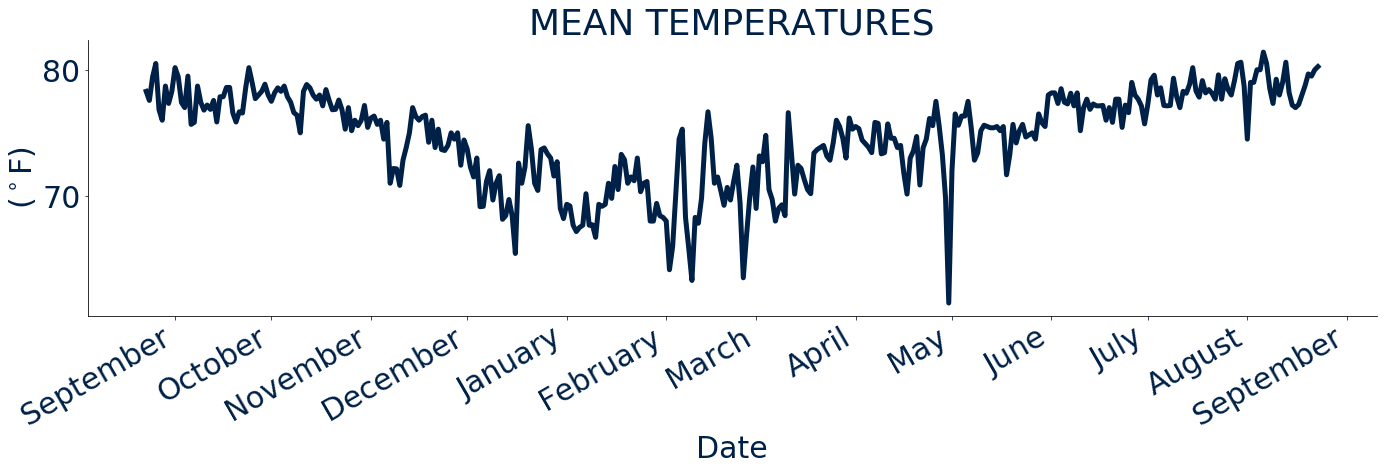

In [33]:
plt.rcParams.update({'font.size': 30})
plt.rcParams['axes.axisbelow'] = True

COLOR = '#002147'
plt.rcParams['text.color'] = COLOR
plt.rcParams['axes.labelcolor'] = COLOR
plt.rcParams['xtick.color'] = COLOR
plt.rcParams['ytick.color'] = COLOR
plt.rcParams['lines.color'] = COLOR
plt.rcParams['lines.linewidth'] = 2

months = mdates.MonthLocator()
months_fmt = mdates.DateFormatter('%B')

fig, ax = plt.subplots(1, figsize = [20, 7.25])

ax.plot(
    year['Date'], 
    year['Temperature'], 
    color = '#002147',
    lw = 5
)

ax.xaxis.set_major_locator(months)
ax.xaxis.set_major_formatter(months_fmt)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_ylabel("($^\circ$F)")
ax.set_xlabel('Date')
ax.set_title('MEAN TEMPERATURES')

fig.autofmt_xdate()

plt.tight_layout()
plt.savefig('Temperature in One Year.png', transparent=True)

plt.show()

#### Describe() Year DataFrame

* Use Pandas to print the summary statistics for the precipitation data

In [11]:
year.describe()

,Temperature,Precipitation
count,366.000000,366.000000
mean,0.978907,74.684071
std,1.776349,3.691031
min,0.000000,61.500000
25%,0.052500,72.290000
50%,0.405000,75.500000
75%,1.087500,77.570000
max,14.280000,81.400000


<center><h2>Station Analysis</center></h2>

* Design a query to calculate the total number of stations

#### Pandas / SQL

In [12]:
# Design a query to show how many stations are available in this dataset?
station_count = pd.read_sql('''SELECT count(station) 
                               FROM station;''', conn).iloc[0, 0]

print(f"There are {station_count} stations in the dataset.")

There are 9 stations in the dataset.


#### SQLAlchemy ORM

In [13]:
select = [
    func.count(Station.station)
]

station_count = session.query(
    *select
).all()

print(f'There are {station_count[0][0]} stations in the dataset.')

There are 9 stations in the dataset.


* Design a query to find the most active stations.
    * List the stations and observation counts in descending order
    * Which station has the highest number of observations?

#### Pandas / SQL

In [14]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
active_stations = pd.read_sql('''SELECT m.station AS Station, 
                                    count(m.station) AS Count,
                                    s.name AS Name,
                                    round(avg(m.tobs), 2) AS Temperature, 
                                    round(avg(m.prcp), 2) AS Precipitation,
                                    s.latitude AS Lat,
                                    s.longitude AS Lon
                                 FROM measurement AS m
                                 LEFT JOIN station AS s
                                 ON m.Station = s.station
                                 GROUP BY m.station
                                 ORDER BY Count ASC;''', conn)

#active_stations.sort_values('Count', ascending=False)
active_stations['Years'] = round(active_stations['Count'] / 365, 2)
active_stations

,Station,Count,Name,Temperature,Precipitation,Lat,Lon,Years
0,USC00518838,511,"UPPER WAHIAWA 874.3, HI US",72.72,0.21,21.49920,-158.01110,1.40
1,USC00517948,1372,"PEARL CITY, HI US",74.68,0.06,21.39340,-157.97510,3.76
2,USC00511918,1979,"HONOLULU OBSERVATORY 702.2, HI US",71.62,0.05,21.31520,-157.99920,5.42
3,USC00514830,2202,"KUALOA RANCH HEADQUARTERS 886.9, HI US",74.87,0.12,21.52130,-157.83740,6.03
4,USC00516128,2612,"MANOA LYON ARBO 785.2, HI US",70.92,0.43,21.33310,-157.80250,7.16
5,USC00519523,2669,"WAIMANALO EXPERIMENTAL FARM, HI US",74.54,0.11,21.33556,-157.71139,7.31
6,USC00513117,2709,"KANEOHE 838.1, HI US",72.69,0.14,21.42340,-157.80150,7.42
7,USC00519397,2724,"WAIKIKI 717.2, HI US",74.55,0.05,21.27160,-157.81680,7.46
8,USC00519281,2772,"WAIHEE 837.5, HI US",71.66,0.21,21.45167,-157.84889,7.59


#### SQLAlchemy ORM

In [15]:
select = [
    Measurement.station.label('Station'), 
    func.count(Measurement.station).label('Count'), 
    Station.name.label('Name'), 
    func.avg(Measurement.tobs).label('Temperature'), 
    func.avg(Measurement.prcp).label('Precipitation'), 
    Station.latitude.label('Lat'), 
    Station.longitude.label('Lon')
]

results = session.query(
    *select
).filter(
    Measurement.station == Station.station
).group_by(
    Measurement.station
).order_by(
    'Count'
).all()

results_dict = {
    'Station': [result[0] for result in results],
    'Count': [result[1] for result in results],
    'Name': [result[2] for result in results],
    'Temperature': [result[3] for result in results],
    'Precipitation': [result[4] for result in results],
    'Lat': [result[5] for result in results],
    'Lon': [result[6] for result in results]
}

active_stations = pd.DataFrame(results)

active_stations['Years'] = active_stations['Count'] / 365
active_stations = round(active_stations, 2)

active_stations

,Station,Count,Name,Temperature,Precipitation,Lat,Lon,Years
0,USC00518838,511,"UPPER WAHIAWA 874.3, HI US",72.72,0.21,21.50,-158.01,1.40
1,USC00517948,1372,"PEARL CITY, HI US",74.68,0.06,21.39,-157.98,3.76
2,USC00511918,1979,"HONOLULU OBSERVATORY 702.2, HI US",71.62,0.05,21.32,-158.00,5.42
3,USC00514830,2202,"KUALOA RANCH HEADQUARTERS 886.9, HI US",74.87,0.12,21.52,-157.84,6.03
4,USC00516128,2612,"MANOA LYON ARBO 785.2, HI US",70.92,0.43,21.33,-157.80,7.16
5,USC00519523,2669,"WAIMANALO EXPERIMENTAL FARM, HI US",74.54,0.11,21.34,-157.71,7.31
6,USC00513117,2709,"KANEOHE 838.1, HI US",72.69,0.14,21.42,-157.80,7.42
7,USC00519397,2724,"WAIKIKI 717.2, HI US",74.55,0.05,21.27,-157.82,7.46
8,USC00519281,2772,"WAIHEE 837.5, HI US",71.66,0.21,21.45,-157.85,7.59


#### Station Activity Barplot

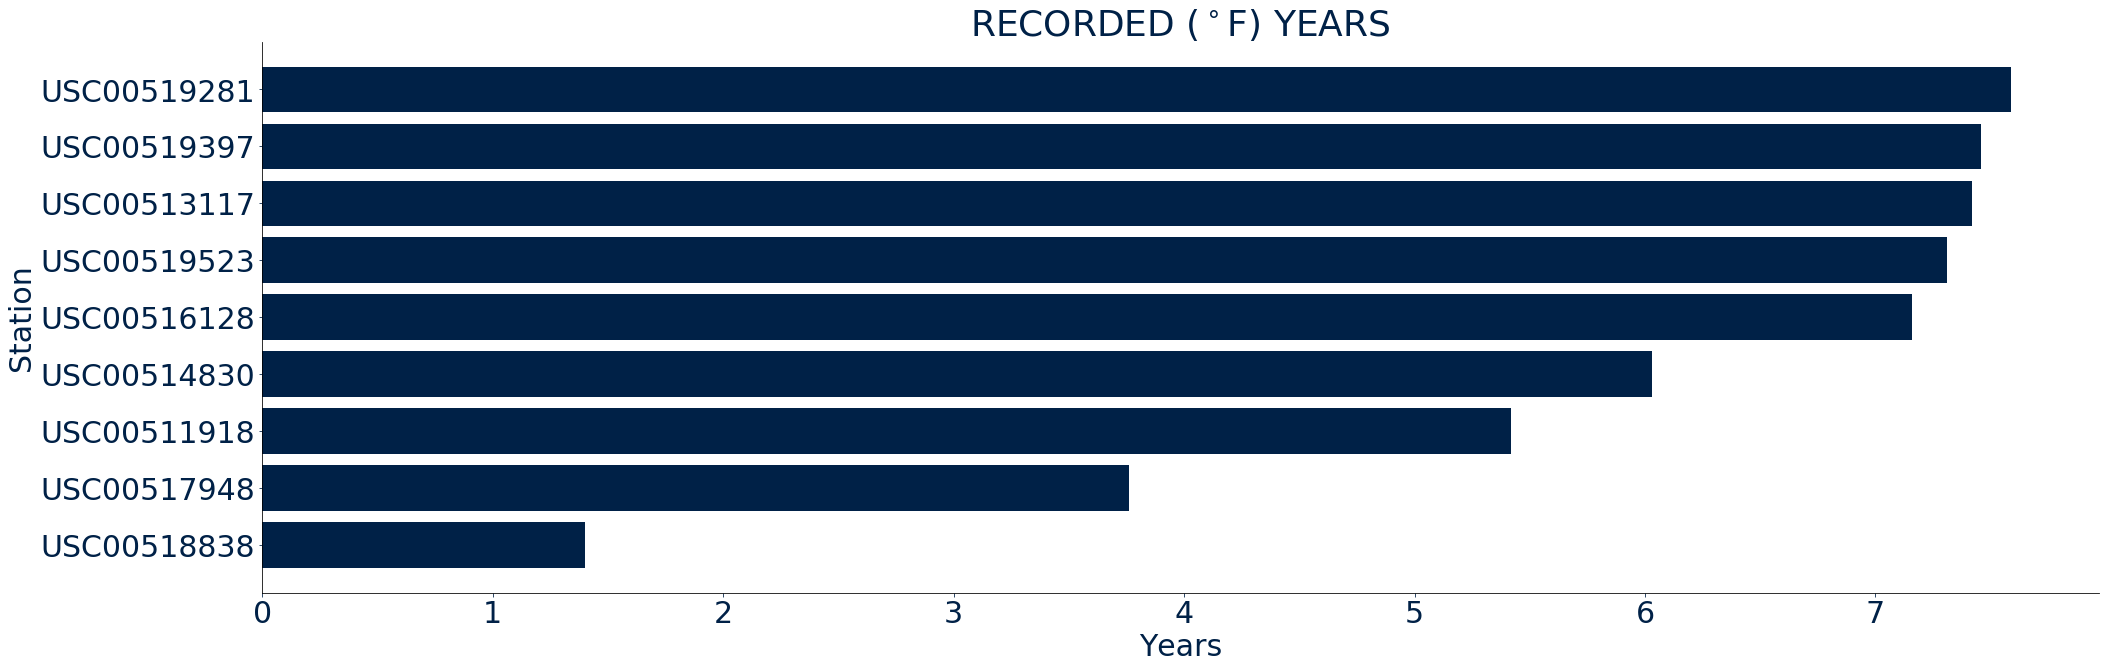

In [16]:
plt.rcParams.update({'font.size': 30})
plt.rcParams['axes.axisbelow'] = True

COLOR = '#002147'
plt.rcParams['text.color'] = COLOR
plt.rcParams['axes.labelcolor'] = COLOR
plt.rcParams['xtick.color'] = COLOR
plt.rcParams['ytick.color'] = COLOR
plt.rcParams['lines.color'] = COLOR
plt.rcParams['lines.linewidth'] = 2

fig, ax = plt.subplots(1, figsize = [30, 10])

ax.barh(
    active_stations['Station'], 
    active_stations['Years'], 
    color = '#002147'
)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_ylabel('Station')
ax.set_xlabel('Years')
ax.set_title('RECORDED ($^\circ$F) YEARS')

plt.tight_layout()
plt.savefig('Active Stations.png', transparent=True)

plt.show()

* Using the station id from the previous query, calculate the lowest temperature recorded, highest temperature recorded, and average temperature for the most active station.

#### Pandas / SQL

In [17]:
pd.read_sql("""SELECT min(tobs) AS Lowest, round(avg(tobs), 2) AS Average, max(tobs) AS Highest
               FROM measurement
               WHERE station = 'USC00519281';""", conn)

,Lowest,Average,Highest
0,54.0,71.66,85.0


#### SQLAlchemy ORM

In [18]:
select = [
    func.min(Measurement.tobs).label('Lowest'), 
    func.avg(Measurement.tobs).label('Average'), 
    func.max(Measurement.tobs).label('Highest')]

results = session.query(*select).filter(Measurement.station == 'USC00519281').all()

results_dict = {
    'Lowest': [result[0] for result in results],
    'Average': [result[1] for result in results],
    'Highest': [result[2] for result in results]
}

round(pd.DataFrame(results_dict, index = ['Values']), 2)

,Lowest,Average,Highest
Values,54.0,71.66,85.0


* Design a query to retrieve the last 12 months of temperature observation data (tobs).
    * Filter by the station with the highest number of observations
    * Plot the results as a histogram with bins = 12.

#### Pandas / SQL

In [19]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
year_station = pd.read_sql("""SELECT date AS Date, 
                              tobs AS Temperature
                              FROM measurement
                              WHERE station = 'USC00519281'
                              AND Date >= '2016-08-18';""", conn)
year_station['Date'] = pd.to_datetime(year_station['Date'])
year_station.head()

,Date,Temperature
0,2016-08-18,80.0
1,2016-08-19,79.0
2,2016-08-20,81.0
3,2016-08-21,79.0
4,2016-08-22,78.0


#### SLQAlchemy ORM

In [20]:
select = [
    Measurement.date.label('Date'), 
    Measurement.tobs.label('Temperature')
]

results = session.query(
    *select
).filter(
    Measurement.station == 'USC00519281'
).filter(
    Measurement.date >= '2016-08-23'
).all()

results_dict = {
    'Date': [result[0] for result in results],
    'Temperature': [result[1] for result in results]
}

year_station = pd.DataFrame(results_dict)
year_station.head()

,Date,Temperature
0,2016-08-23,77.0
1,2016-08-24,77.0
2,2016-08-25,80.0
3,2016-08-26,80.0
4,2016-08-27,75.0


#### Histogram of Station USC00519281-WAIHEE 837.5 

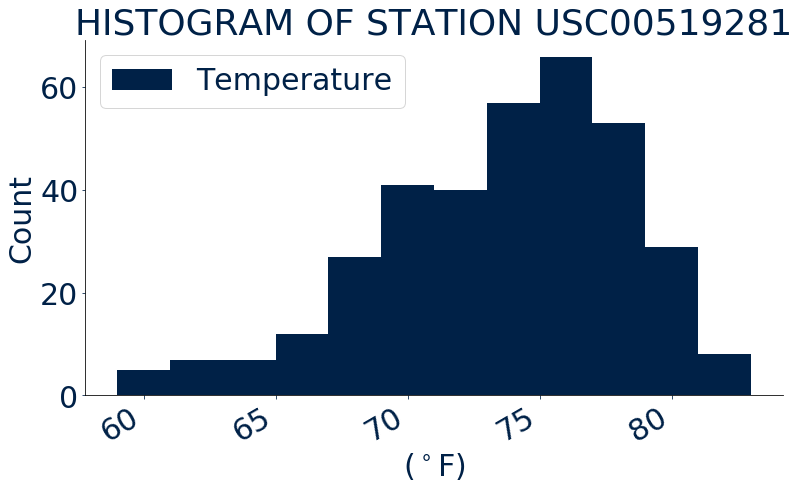

In [21]:
plt.rcParams.update({'font.size': 30})
plt.rcParams['axes.axisbelow'] = True

COLOR = '#002147'
plt.rcParams['text.color'] = COLOR
plt.rcParams['axes.labelcolor'] = COLOR
plt.rcParams['xtick.color'] = COLOR
plt.rcParams['ytick.color'] = COLOR
plt.rcParams['lines.color'] = COLOR
plt.rcParams['lines.linewidth'] = 2


fig, ax = plt.subplots(1, figsize = [12, 7.5])

ax.hist(
    year_station['Temperature'], 
    bins = 12, 
    color = '#002147', 
    lw = 5
)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_xlabel('($^\circ$F)')
ax.set_ylabel('Count')
ax.set_title('HISTOGRAM OF STATION USC00519281')

fig.autofmt_xdate()

plt.legend()
plt.tight_layout()
plt.savefig('Histogram of Station USC00519281.png', transparent=True)

plt.show()

<center><h1>Part 2 - Climate App</center></h1>
* Please see: climate.py

### Optional: Other Recommended Analyses

* The following are optional challenge queries. These are highly recommended to attempt, but not required for the homework.

<center><h1>Temperature Analysis 1</h1></center>

* Hawaii is reputed to enjoy mild weather all year. Is there a meaningful difference between the temperature in, for example, June and December?
* You may either use SQLAlchemy or pandas's read_csv() to perform this portion.
* Identify the average temperature in June at all stations across all available years in the dataset. Do the same for December temperature.
* Use the t-test to determine whether the difference in the means, if any, is statistically significant. Will you use a paired t-test, or an unpaired t-test? Why?

<center><h1>Temperature Analysis 2</h1></center>

* The starter notebook contains a function called calc_temps that will accept a start date and end date in the format %Y-%m-%d and return the minimum, average, and maximum temperatures for that range of dates.
* Use the calc_temps function to calculate the min, avg, and max temperatures for your trip using the matching dates from the previous year (i.e., use "2017-01-01" if your trip start date was "2018-01-01").

* Plot the min, avg, and max temperature from your previous query as a bar chart.
    * Use the average temperature as the bar height.
    * Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr).

<center><h1>Daily Rainfall Average</h1></center>

* Calculate the rainfall per weather station using the previous year's matching dates.
* Calculate the daily normals. Normals are the averages for the min, avg, and max temperatures.
* You are provided with a function called daily_normals that will calculate the daily normals for a specific date. This date string will be in the format %m-%d. Be sure to use all historic tobs that match that date string.
* Create a list of dates for your trip in the format %m-%d. Use the daily_normals function to calculate the normals for each date string and append the results to a list.
* Load the list of daily normals into a Pandas DataFrame and set the index equal to the date.
* Use Pandas to plot an area plot (stacked=False) for the daily normals.

In [22]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [23]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [24]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [25]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [26]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)



def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [27]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [28]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [29]:
# Plot the daily normals as an area plot with `stacked=False`
